In [2]:
%pylab inline

import seaborn as sns
import pandas as pd
from datetime import datetime, timedelta
import re

from scipy.optimize import fmin
from scipy.stats import gamma, beta
import numpy as np

sns.set_style('ticks')
sns.set_context('talk')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 2000)

Populating the interactive namespace from numpy and matplotlib


In [3]:
def get_current_los(d):
    """Handy utility function to help you figure out the LOS for patients who haven't been discharged."""
    now = datetime.now()
    now = datetime(now.year, now.month, now.day)
    return(now - d).total_seconds() / 86400.0

def gamma_from_q(l, u, quantiles_percent=0.95):
    def loss(params):
        a, b = params
        lq = (1 - quantiles_percent) / 2
        uq = 1 - lq
        return ( (gamma.cdf(l, a, scale=b) - lq)**2 + (gamma.cdf(u, a, scale=b) - uq)**2 )

    start_params = (5, 5)
    fit = fmin(loss, start_params, disp=0)
    return fit

def beta_from_q(l, u, quantiles_percent=0.95):
    def loss(params):
        a, b = params
        lq = (1 - quantiles_percent) / 2
        uq = 1 - lq
        return ( (beta.cdf(l, a, b) - lq)**2 + (beta.cdf(u, a, b) - uq)**2 )

    start_params = (1, 1)
    fit = fmin(loss, start_params, disp=0)
    return fit

def plot_prior(lower, upper, dist=None, kind='gamma', max_val=100):
    """Plot priors for inspection.
    
    kind: 'gamma' or 'beta'
    """
    from_q, pdf = gamma_from_q, lambda x, a, scale: gamma.pdf(x, a, scale=scale), 
    if kind == 'beta':
        from_q, pdf, max_val = beta_from_q, lambda x, a, b: beta.pdf(x, a, b), 1
    print(f'lower: {lower}, upper: {upper}')
    params = from_q(lower, upper)
    fig, ax = plt.subplots(1,1, figsize=(7, 3.5))
    x = np.linspace(0, max_val, max_val*100)
    ax.plot(x, pdf(x, params[0], params[1]))
    ax.axvline(lower,ls='--')
    ax.axvline(upper,ls='--')
    if dist:
        ax2 = ax.twinx()
        pd.Series(dist).hist(ax=ax2, alpha=0.5)
        ax.set_xlim(tuple(np.percentile(dist, [0.1, 99.9])))
    print('Distribution: parameter 1: {}, parameter 2: {}'.format(params[0], params[1]))

## Creating a prior for social distancing

Let's say you want to use some published social distancing data to create a better informed prior on this parameter? One such source of data might be [Google's COVID-19 mobility data](https://github.com/kurtmaia/google_covid_data/blob/master/regionLevel.csv).

lower: 0.25, upper: 0.45
Distribution: parameter 1: 29.629392620168048, parameter 2: 55.85642665969445


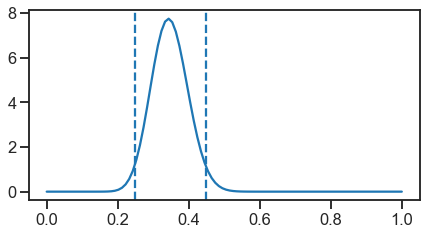

In [4]:
plot_prior(0.25, 0.45, kind='beta')

You can now use these parameters as input to BayesCHIME's [`logistic_L`](https://github.com/pennsignals/chime_sims/blob/240bcc10ed896e2c5ab6d13281d632b8490320b1/data/CCH_parameters.csv#L18) parameters.

## Creating a prior for mean hospital LOS
We have emprical data that can be used to estimate the prior distruibution for hospital LOS. If we gather data on the LOS of all current and past COVID-19 patients at our hospitals we can use survival analysis to estimate the true distribution of LOS means to create a data informed prior for our model.

In [5]:
survival_data = pd.read_csv('ICU_LOS_survival.csv')
survival_data.head()

,ICU_LOS,Observed
0,6.056250,True
1,9.143055,True
2,6.178472,True
3,22.448611,True
4,1.087500,True


* **LOS** should be the actual LOS for discharged patients and the censored (up till today) LOS for in-house patients
* **Observed** is a boolean to indicate if the patient has already been discharged (discharged == True, in-house == False)

In [6]:
T = survival_data["ICU_LOS"]
E = survival_data["Observed"]

In [7]:
from lifelines import WeibullFitter, KaplanMeierFitter

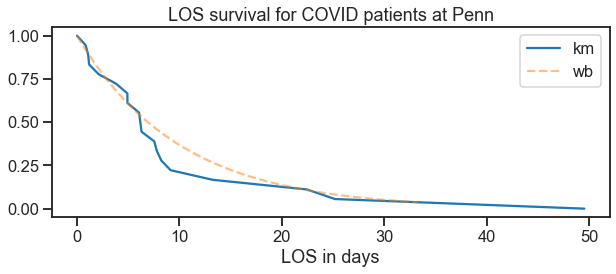

In [8]:
timeline = np.linspace(0, 100, 400) # assume max LOS of 100 days
kmf = KaplanMeierFitter().fit(T, event_observed=E)
wbf = WeibullFitter().fit(T, E, timeline=timeline, label='WeibullFitter')

fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))
ax.plot(kmf.survival_function_, label='km')
ax.plot(wbf.survival_function_.head(134), label='wb', alpha=0.5, ls='--')
ax.set_title('LOS survival for COVID patients at Penn')
ax.set_xlabel('LOS in days')
_ = ax.legend(loc=0)

The Weibull survival curve is pretty easy to sample from as follows... keep drawing samples till the mean converges (around 2k for my data)

In [9]:
means = []
while len(means) < 2000:
    for i in range(10):
        samps_probs = np.random.uniform(size=survival_data.shape[0])
        samps = []
        for a in samps_probs:
            samps.append(wbf.survival_function_[wbf.survival_function_['WeibullFitter'] <= a].index[0])
        means.append(np.mean(samps))
    mm = np.mean(means)
    print(f'{mm:.3f}', end=' ')

9.738 9.893 10.001 10.415 10.272 10.248 10.206 10.266 10.228 10.278 10.211 10.258 10.315 10.338 10.285 10.267 10.245 10.282 10.289 10.351 10.355 10.320 10.323 10.309 10.311 10.315 10.296 10.319 10.288 10.279 10.271 10.229 10.226 10.203 10.216 10.229 10.247 10.262 10.259 10.224 10.238 10.243 10.251 10.260 10.257 10.281 10.286 10.299 10.294 10.318 10.312 10.311 10.301 10.309 10.293 10.303 10.304 10.297 10.322 10.332 10.325 10.318 10.321 10.306 10.288 10.285 10.288 10.286 10.284 10.274 10.274 10.284 10.285 10.279 10.285 10.268 10.263 10.253 10.241 10.243 10.233 10.238 10.233 10.221 10.234 10.222 10.228 10.208 10.204 10.195 10.186 10.179 10.166 10.165 10.172 10.179 10.172 10.169 10.179 10.179 10.177 10.175 10.177 10.173 10.179 10.182 10.181 10.190 10.195 10.196 10.211 10.217 10.217 10.219 10.214 10.222 10.202 10.195 10.193 10.195 10.202 10.206 10.198 10.195 10.191 10.187 10.186 10.191 10.192 10.195 10.200 10.194 10.189 10.188 10.196 10.195 10.195 10.196 10.188 10.185 10.189 10.184 10.187 1

lower: 6.152534113060429, upper: 15.069270398217744
Distribution: parameter 1: 19.634865510650496, parameter 2: 0.5156308477008621


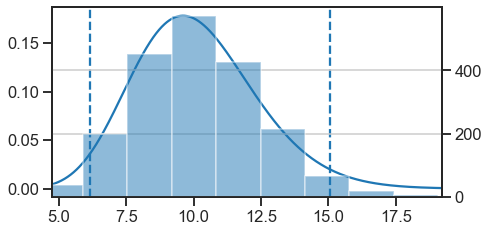

In [11]:
lower, upper = tuple(np.percentile(means, [2.5, 97.5]))
plot_prior(lower, upper, dist=means)

You can now use these parameters as input to BayesCHIME's [`hosp_LOS`](https://github.com/pennsignals/chime_sims/blob/240bcc10ed896e2c5ab6d13281d632b8490320b1/data/CCH_parameters.csv#L9) parameters.<br>
*Note: Don't forget to also update you prior on `ICU_LOS` if needed. Unlike CHIME, ICU_LOS only counts the amount of time spent in the ICU for patients who require ICU* 